# Assessment 1: Predict diabetes using Perceptron

## Overview

The first assignment is to implement, describe, and test
a specific algorithm called Perceptron (which can be
interpreted as a dense layer neural network) for predicting
diabetes (using the diabetes dataset provided). 

## Import Packages


In [241]:
# Common imports
import numpy as np
import pandas as pd

# visualizaiton
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning & Deep learning imports
import sklearn
import torch


## Data Loading

In [242]:
# Load data
df = pd.read_csv('diabetes.csv')  # Adjust path and file name as necessary

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

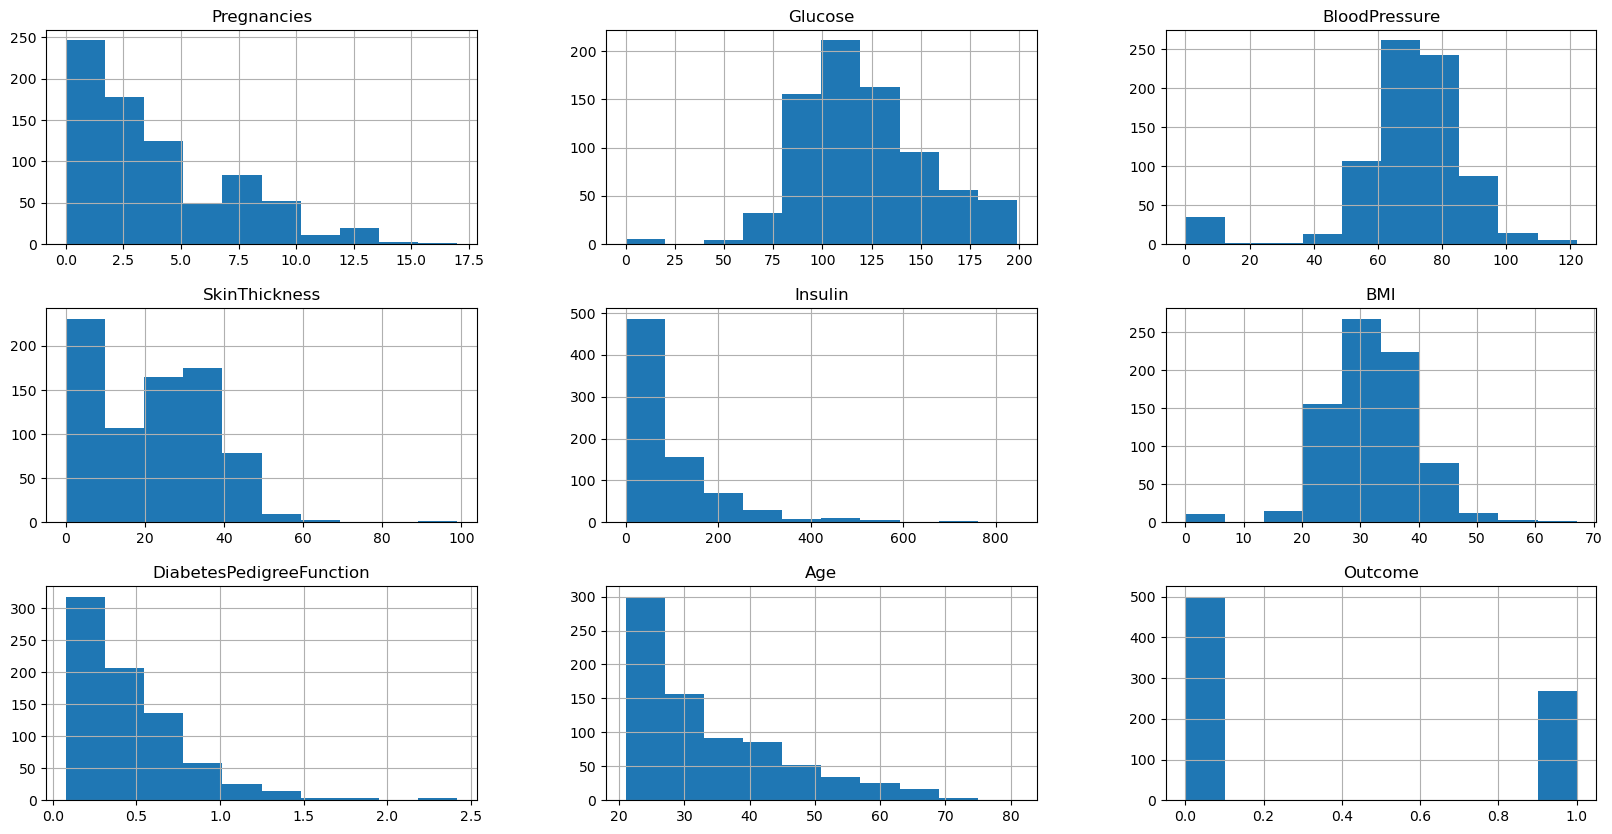

In [243]:
df.hist(figsize=(20,10))

## Check NaN values and the distribution of each feature

In [244]:
features_np = df.drop(columns=['Outcome']).to_numpy()  # Drop the label column and convert to numpy array
df['Outcome'] = df['Outcome'].replace(0, -1)
labels_np = df['Outcome'].to_numpy()      

In [245]:
# Check dataframe
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,-0.302083
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.953903
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,-1.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,-1.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,-1.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Perceptron Model

In [246]:
import torch.nn as nn
import torch.optim as optim

class PyTorchPerceptron(nn.Module):
    def __init__(self, input_dim):
        super(PyTorchPerceptron, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1),               
        )
    
    def forward(self, x):
        return self.fc(x)

In [247]:
def perceptron_loss(outputs, labels):
    # Compute the perceptron loss
    loss = torch.clamp(-labels * outputs, min=0)
    return torch.mean(loss)

In [248]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, ClassifierMixin

class PyTorchPerceptronClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, epochs=20, batch_size=16, learning_rate=0.001, patience=6, min_delta=0.001):
        self.input_dim = input_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.patience = patience
        self.min_delta = min_delta
        self.model = PyTorchPerceptron(input_dim)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.best_params = None  # To store the best model parameters
        self.best_val_loss = np.inf
        self.epochs_no_improve = 0
        self.training_losses = []
        self.validation_losses = []

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        X_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
        train_dataset = TensorDataset(X_tensor, y_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        val_loader = None
        if X_val is not None and y_val is not None:
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        self.model.train()
        for epoch in range(self.epochs):
            total_train_loss = 0
            for inputs, targets in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = perceptron_loss(outputs, targets)
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item()
            # Calculate average training loss for the epoch and append it to training_losses
            avg_train_loss = total_train_loss / len(train_loader)
            self.training_losses.append(avg_train_loss)

            if val_loader:
                self.model.eval()
                total_val_loss = 0
                with torch.no_grad():
                    for inputs, targets in val_loader:
                        outputs = self.model(inputs)
                        loss = perceptron_loss(outputs, targets)
                        total_val_loss += loss.item()

                avg_val_loss = total_val_loss / len(val_loader)
                self.validation_losses.append(avg_val_loss)

                # Early stopping and model saving logic
                if avg_val_loss < self.best_val_loss:
                    if self.best_val_loss - avg_val_loss > self.min_delta:
                        self.best_val_loss = avg_val_loss
                        self.best_params = {k: v.clone() for k, v in self.model.state_dict().items()}  # Deep copy the model params
                        self.epochs_no_improve = 0
                else:
                    self.epochs_no_improve += 1

                if self.epochs_no_improve >= self.patience:
                    print("Early stopping triggered")
                    self.model.load_state_dict(self.best_params)  # Restore the best parameters
                    break

                print(f"Epoch {epoch+1}/{self.epochs}: Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {avg_val_loss:.4f}")

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor)
        return (outputs.numpy() > 0).astype(int)*2 - 1

    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

## Pipeline of imputation and training

In [250]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,-0.302083
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.953903
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,-1.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,-1.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,-1.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [291]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame
# Replace 0 with -1 in 'Outcome' before the split
df['Outcome'] = df['Outcome'].replace(0, -1)

# Splitting the data into train and test sets
X = df.drop(columns=['Outcome'])
y = df['Outcome']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [292]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
638,7,97,76,32,91,40.9,0.871,32
236,7,181,84,21,192,35.9,0.586,51
165,6,104,74,18,156,29.9,0.722,41
729,2,92,52,0,0,30.1,0.141,22
281,10,129,76,28,122,35.9,0.280,39


In [293]:
# Convert columns to float if they are not already to ensure data type compatibility
X_train[['Glucose', 'BloodPressure', 'BMI', 'SkinThickness']] = X_train[['Glucose', 'BloodPressure', 'BMI', 'SkinThickness']].astype(float)
X_test[['Glucose', 'BloodPressure', 'BMI', 'SkinThickness']] = X_test[['Glucose', 'BloodPressure', 'BMI', 'SkinThickness']].astype(float)

# Calculate medians for the training data, ignoring zeros
glucose_median = X_train.loc[X_train['Glucose'] > 0, 'Glucose'].median()
blood_pressure_median = X_train.loc[X_train['BloodPressure'] > 0, 'BloodPressure'].median()
bmi_median = X_train.loc[X_train['BMI'] > 0, 'BMI'].median()
skin_thickness_median = X_train.loc[X_train['SkinThickness'] > 0, 'SkinThickness'].median()

# Apply imputation to the training set
X_train.loc[X_train['Glucose'] == 0, 'Glucose'] = glucose_median
X_train.loc[X_train['BloodPressure'] == 0, 'BloodPressure'] = blood_pressure_median
X_train.loc[X_train['BMI'] == 0, 'BMI'] = bmi_median
X_train.loc[X_train['SkinThickness'] == 0, 'SkinThickness'] = skin_thickness_median

# Apply the same imputation values to the test set
X_test.loc[X_test['Glucose'] == 0, 'Glucose'] = glucose_median
X_test.loc[X_test['BloodPressure'] == 0, 'BloodPressure'] = blood_pressure_median
X_test.loc[X_test['BMI'] == 0, 'BMI'] = bmi_median
X_test.loc[X_test['SkinThickness'] == 0, 'SkinThickness'] = skin_thickness_median

# Convert columns to float in the validation set for data type compatibility
X_val[['Glucose', 'BloodPressure', 'BMI', 'SkinThickness']] = X_val[['Glucose', 'BloodPressure', 'BMI', 'SkinThickness']].astype(float)

# Apply the imputation to the validation set using the medians calculated from the training set
X_val.loc[X_val['Glucose'] == 0, 'Glucose'] = glucose_median
X_val.loc[X_val['BloodPressure'] == 0, 'BloodPressure'] = blood_pressure_median
X_val.loc[X_val['BMI'] == 0, 'BMI'] = bmi_median
X_val.loc[X_val['SkinThickness'] == 0, 'SkinThickness'] = skin_thickness_median

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>, <Axes: >]], dtype=object)

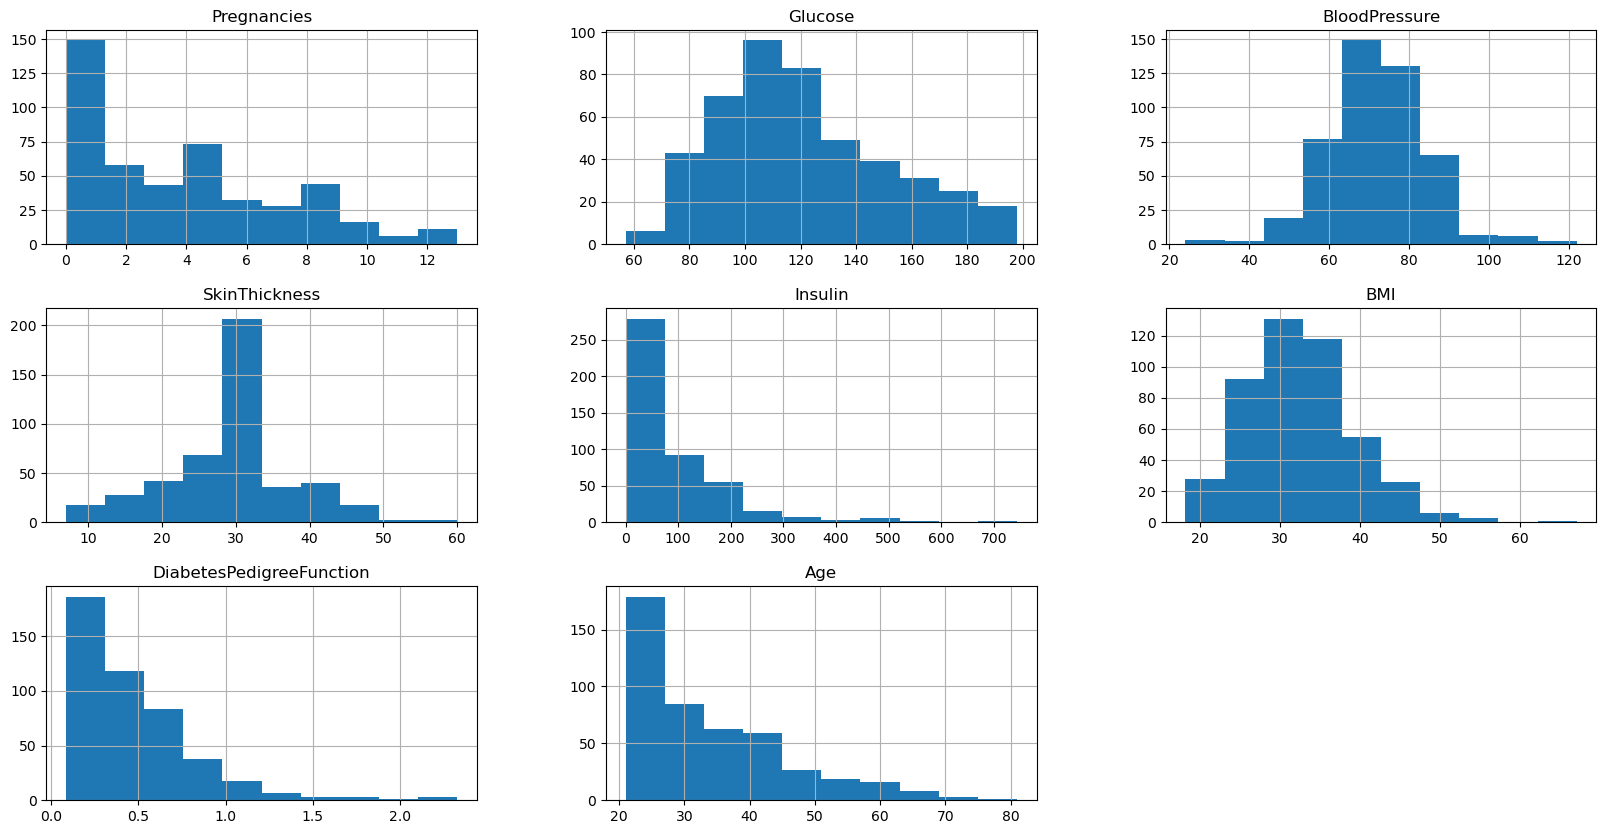

In [294]:
X_train.hist(figsize=(20,10))

In [295]:
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,3.867391,121.184783,72.143478,28.882609,75.784783,32.497826,0.481172,33.306522
std,3.307386,30.453411,12.494054,8.333158,106.470507,6.797116,0.344756,11.633265
min,0.000000,57.000000,24.000000,7.000000,0.000000,18.200000,0.084000,21.000000
25%,1.000000,99.000000,64.000000,26.000000,0.000000,27.800000,0.244500,24.000000
50%,3.000000,116.000000,72.000000,29.000000,34.000000,32.150000,0.382500,29.000000
75%,6.000000,139.250000,80.000000,32.000000,126.750000,36.325000,0.629500,40.000000
max,13.000000,198.000000,122.000000,60.000000,744.000000,67.100000,2.329000,81.000000


In [296]:
Q1 = X_train['Insulin'].quantile(0.25)
Q3 = X_train['Insulin'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold_high = Q3 + 1.5 * IQR

In [297]:
# Removing outliers from the training set
X_train = X_train[X_train['Insulin'] <= outlier_threshold_high]

# Assuming X_val is your validation set and it has been defined similarly
X_val = X_val[X_val['Insulin'] <= outlier_threshold_high]

# Removing outliers from the test set
X_test = X_test[X_test['Insulin'] <= outlier_threshold_high]

In [298]:
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000
mean,3.841986,119.498871,72.090293,28.708804,61.442438,32.421670,0.471666,33.178330
std,3.318991,29.422217,12.515727,8.155091,75.777677,6.811856,0.326464,11.584522
min,0.000000,57.000000,24.000000,7.000000,0.000000,18.200000,0.084000,21.000000
25%,1.000000,98.500000,64.000000,25.500000,0.000000,27.800000,0.244000,24.000000
50%,3.000000,115.000000,72.000000,29.000000,0.000000,32.150000,0.380000,29.000000
75%,6.000000,137.000000,80.000000,32.000000,115.500000,36.250000,0.618000,40.000000
max,13.000000,198.000000,122.000000,60.000000,304.000000,67.100000,2.288000,81.000000


In [299]:
from sklearn.preprocessing import MinMaxScaler
# Initialize the MinMaxScaler with the desired range
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and testing data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# If you need to convert these back to DataFrames:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [300]:
X_train_scaled.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000
mean,-0.408925,-0.113491,-0.018565,-0.180800,-0.595773,-0.418337,-0.648216,-0.594056
std,0.510614,0.417336,0.255423,0.307739,0.498537,0.278604,0.296246,0.386151
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.846154,-0.411348,-0.183673,-0.301887,-1.000000,-0.607362,-0.854809,-0.900000
50%,-0.538462,-0.177305,-0.020408,-0.169811,-1.000000,-0.429448,-0.731397,-0.733333
75%,-0.076923,0.134752,0.142857,-0.056604,-0.240132,-0.261759,-0.515426,-0.366667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

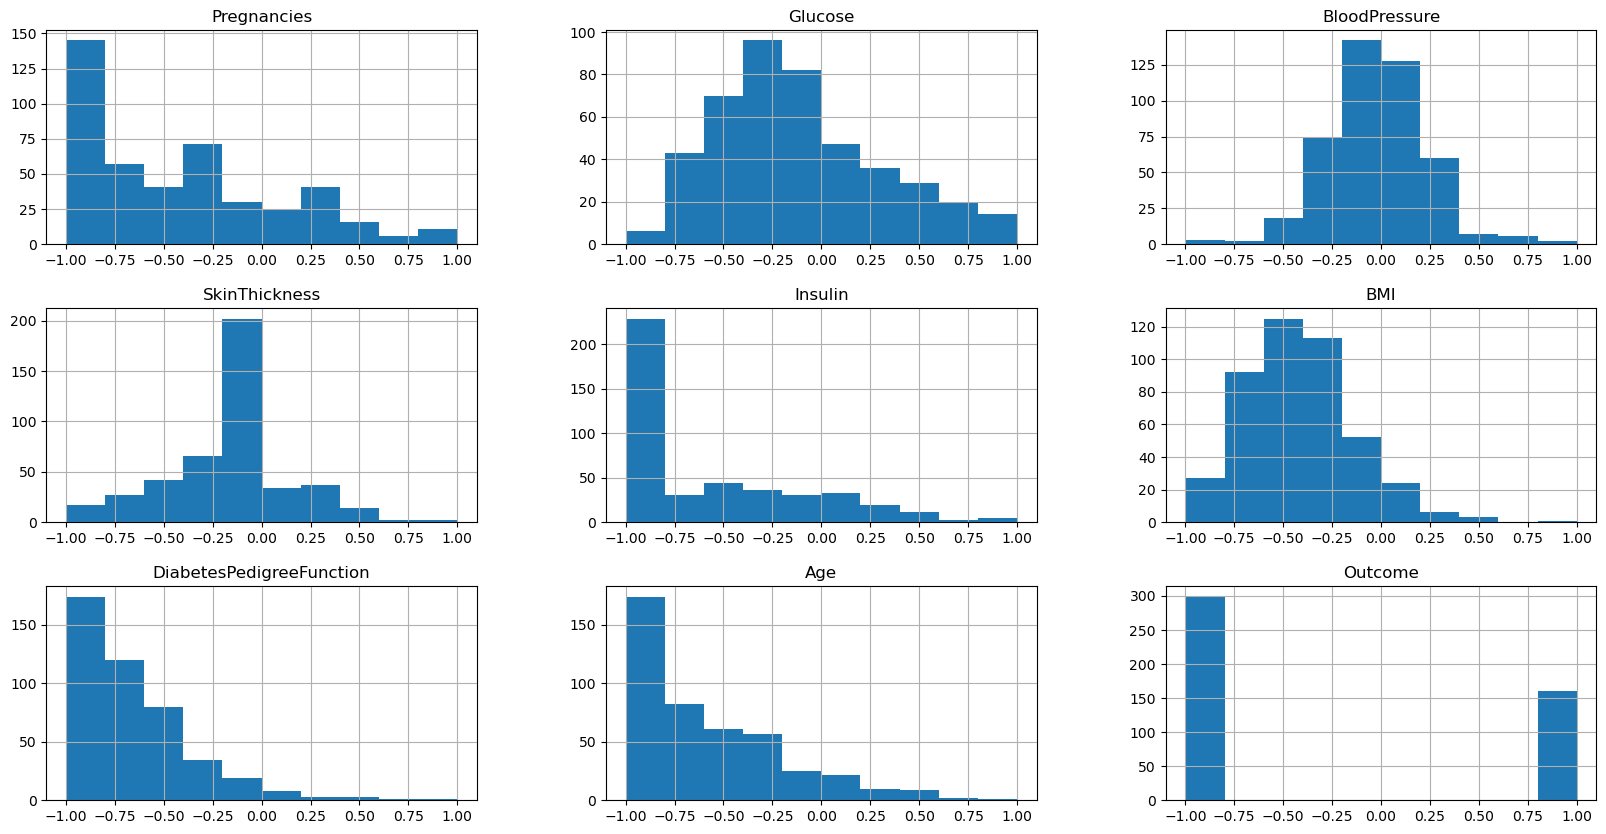

In [301]:
combined_df = pd.concat([X_train_scaled, y_train], axis=1)
combined_df.hist(figsize=(20,10))

In [302]:
# Convert DataFrames to numpy arrays for modeling
X_train = X_train_scaled.to_numpy()
X_val = X_val_scaled.to_numpy()
X_test = X_test_scaled.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [303]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np

# Load and split your data
# X and y should be loaded as numpy arrays from your dataset
X_train, X_temp, y_train, y_temp = train_test_split(features_np, labels_np, test_size=0.4, random_state=42, stratify=labels_np)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [304]:
X_train.shape

(460, 8)

In [343]:
# train the model
classifier = PyTorchPerceptronClassifier(input_dim=X_train.shape[1],epochs=20, batch_size=16, learning_rate=0.01)
classifier.fit(X_train, y_train, X_val=X_val, y_val=y_val)

Epoch 1/20: Train Loss: 6.8425, Val Loss: 2.6054
Epoch 2/20: Train Loss: 1.9320, Val Loss: 1.1487
Epoch 3/20: Train Loss: 1.0296, Val Loss: 0.6178
Epoch 4/20: Train Loss: 0.8836, Val Loss: 0.9200
Epoch 5/20: Train Loss: 0.5266, Val Loss: 0.5895
Epoch 6/20: Train Loss: 0.3586, Val Loss: 0.2002
Epoch 7/20: Train Loss: 0.2752, Val Loss: 0.1029
Epoch 8/20: Train Loss: 0.2762, Val Loss: 0.4347
Epoch 9/20: Train Loss: 0.3350, Val Loss: 0.0988
Epoch 10/20: Train Loss: 0.3358, Val Loss: 0.4504
Epoch 11/20: Train Loss: 0.1944, Val Loss: 0.3547
Epoch 12/20: Train Loss: 0.1884, Val Loss: 0.2167
Epoch 13/20: Train Loss: 0.1732, Val Loss: 0.3599
Epoch 14/20: Train Loss: 0.1483, Val Loss: 0.2295
Early stopping triggered


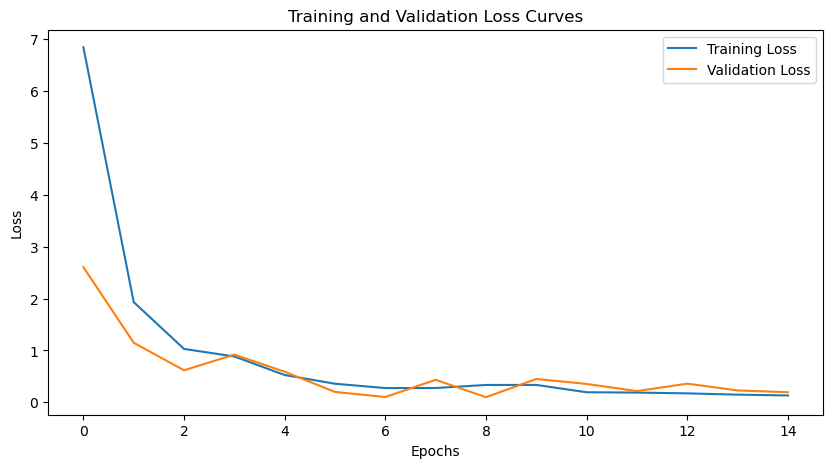

In [344]:
# Plot training and validation losses, assuming these are stored in the classifier after fitting
plt.figure(figsize=(10, 5))
plt.plot(classifier.training_losses, label='Training Loss')
plt.plot(classifier.validation_losses, label='Validation Loss')  
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [345]:
# Predict using the classifier
y_val_pred = classifier.predict(X_val)

In [346]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_val, y_val_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.6429
Confusion Matrix:
 [[76 24]
 [31 23]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.71      0.76      0.73       100
           1       0.49      0.43      0.46        54

    accuracy                           0.64       154
   macro avg       0.60      0.59      0.59       154
weighted avg       0.63      0.64      0.64       154



Epoch 1/20: Train Loss: 6.7785, Val Loss: 1.3520
Epoch 2/20: Train Loss: 0.5830, Val Loss: 0.6153
Epoch 3/20: Train Loss: 0.2909, Val Loss: 0.3150
Epoch 4/20: Train Loss: 0.3538, Val Loss: 0.8981
Epoch 5/20: Train Loss: 0.3347, Val Loss: 0.3907
Epoch 6/20: Train Loss: 0.2761, Val Loss: 0.5424
Epoch 7/20: Train Loss: 0.3563, Val Loss: 0.8166
Epoch 8/20: Train Loss: 0.4607, Val Loss: 0.2291
Epoch 9/20: Train Loss: 0.3983, Val Loss: 0.2663
Epoch 10/20: Train Loss: 0.4705, Val Loss: 0.6237
Epoch 11/20: Train Loss: 0.3462, Val Loss: 0.8418
Epoch 12/20: Train Loss: 0.1714, Val Loss: 0.1189
Epoch 13/20: Train Loss: 0.2365, Val Loss: 0.8633
Epoch 14/20: Train Loss: 0.5395, Val Loss: 0.6180
Epoch 15/20: Train Loss: 0.2708, Val Loss: 0.1714
Epoch 16/20: Train Loss: 0.2896, Val Loss: 0.3618
Epoch 17/20: Train Loss: 0.2756, Val Loss: 0.2565
Early stopping triggered
Epochs: 20, Batch Size: 8, Learning Rate: 0.01
              precision    recall  f1-score   support

          -1       0.78      0.6

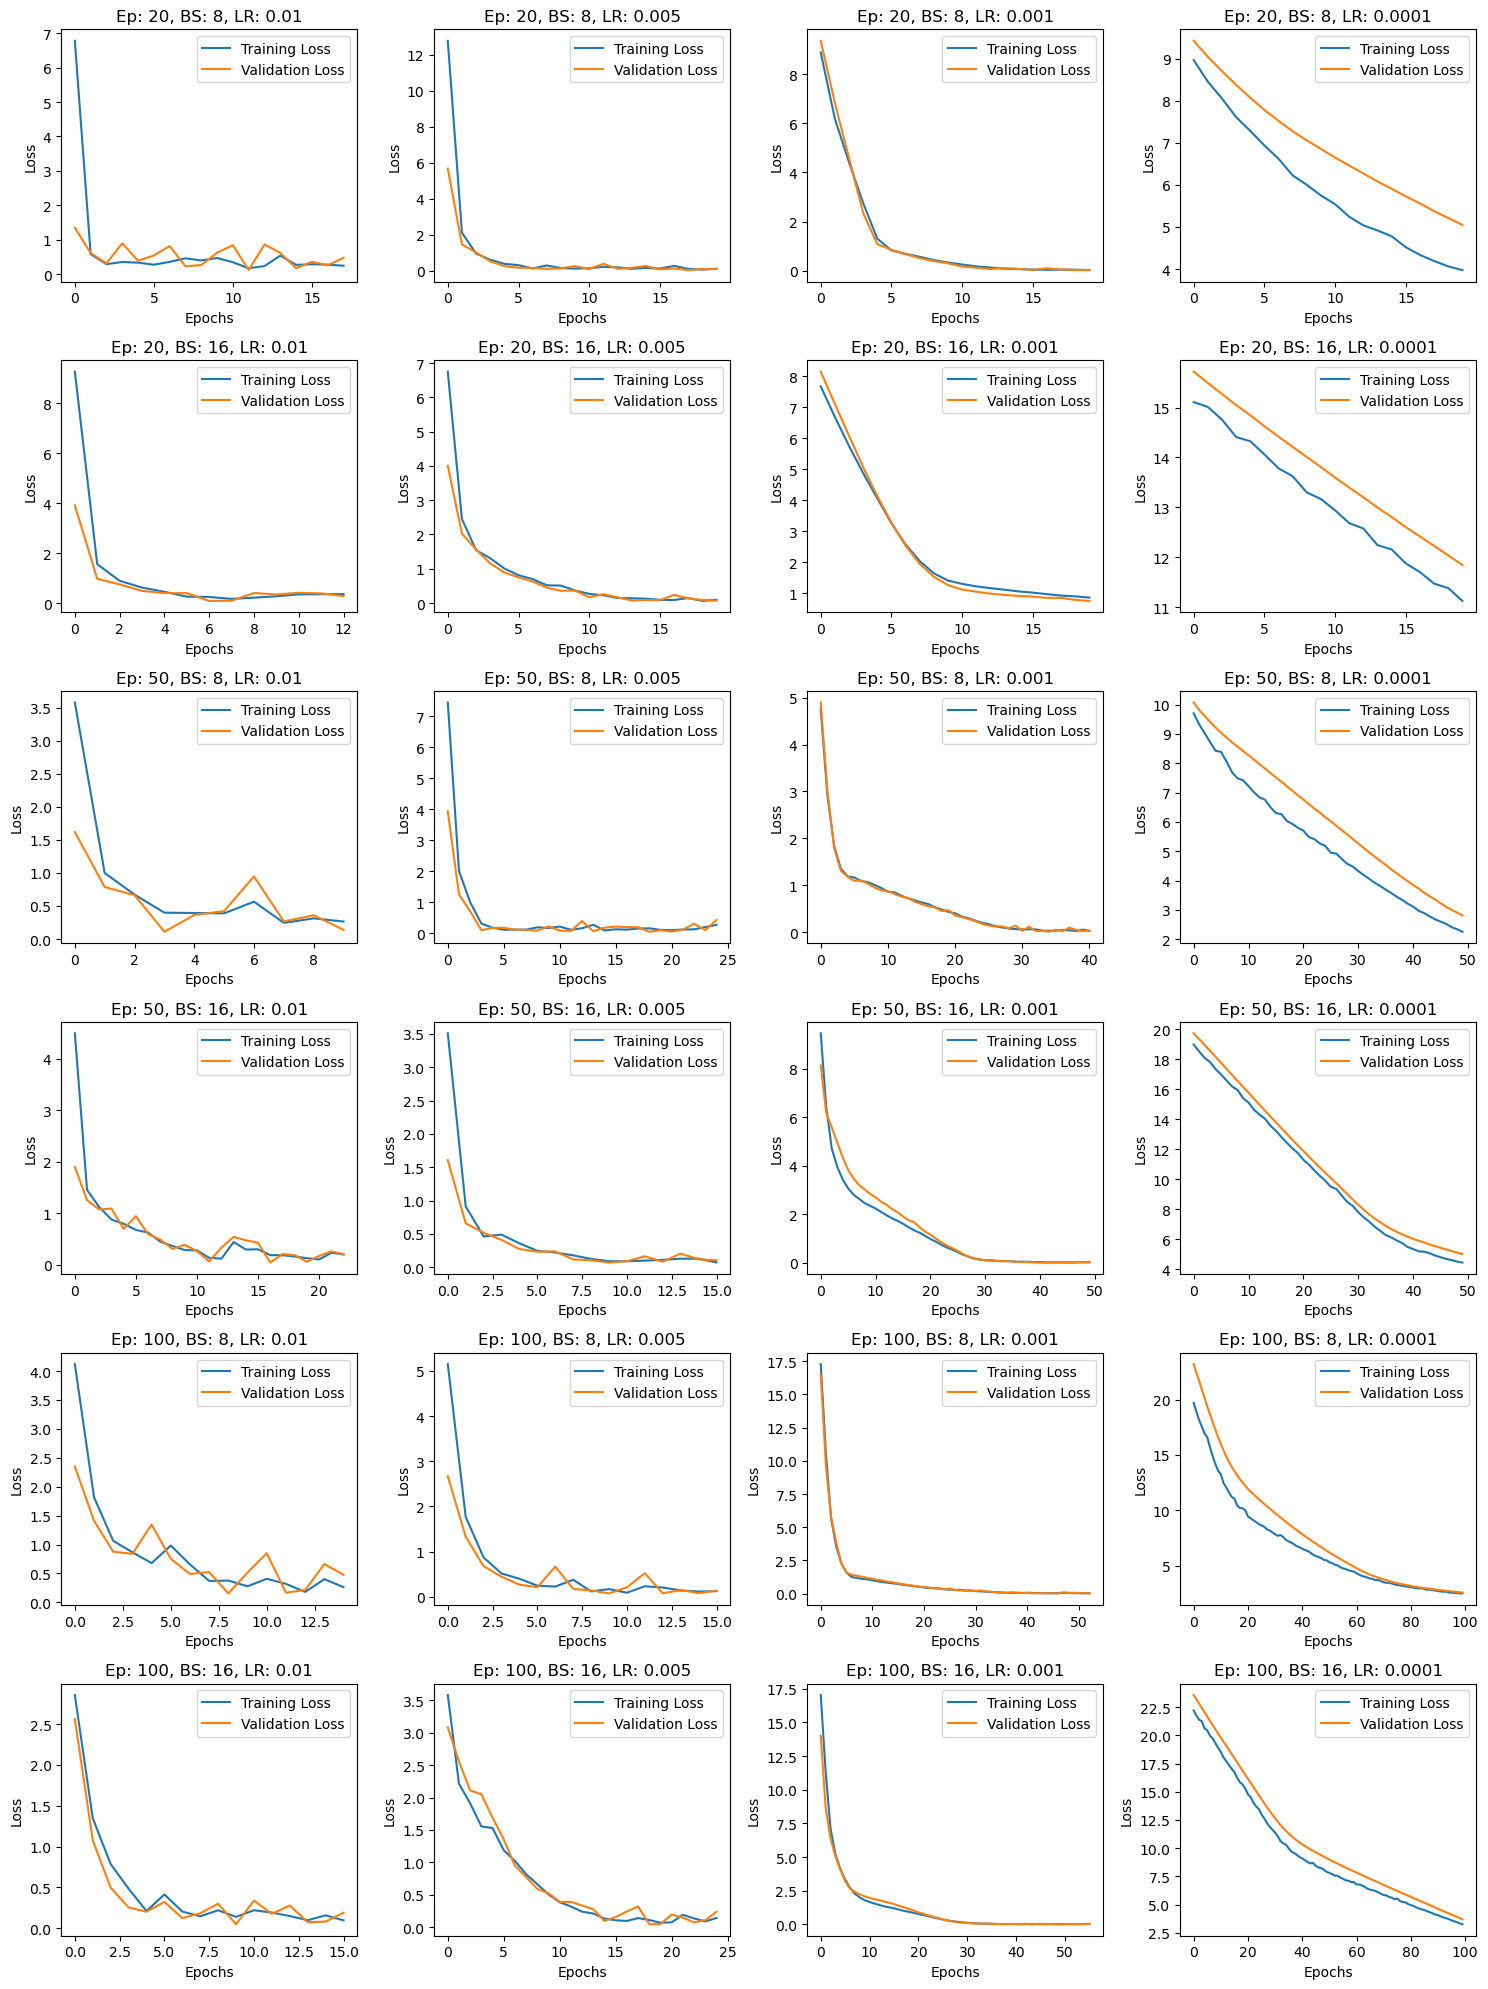

Best F1 score: 0.7058823529411764
Best parameters: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 100, 'f1_score': 0.7058823529411764}


In [361]:
import numpy as np
import torch
from sklearn.metrics import f1_score, classification_report
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Setup for manual hyperparameter tuning
param_grid = {
    'batch_size': [8, 16],
    'learning_rate': [0.01, 0.005, 0.001, 0.0001],
    'epochs': [20, 50, 100]
}
best_f1_score = -np.inf
best_params = {}
all_losses = {}

# Prepare figure for plotting
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 20))  # Adjusted for a 6x4 matrix

# Counter to manage subplot indices
plot_idx = 0

# Iterate over all combinations of hyperparameters
for epoch in param_grid['epochs']:
    for batch_size in param_grid['batch_size']:
        for learning_rate in param_grid['learning_rate']:
            # Initialize the classifier with current set of parameters
            classifier = PyTorchPerceptronClassifier(input_dim=X_train.shape[1], epochs=epoch,
                                                     batch_size=batch_size, learning_rate=learning_rate)
            # Train the model
            classifier.fit(X_train, y_train, X_val=X_val, y_val=y_val)

            # Validate the model
            y_pred = classifier.predict(X_val)

            # Calculate F1 score and classification report
            current_f1_score = f1_score(y_val, y_pred, average='binary')
            current_classification_report = classification_report(y_val, y_pred)

            # Print the classification report
            print(f"Epochs: {epoch}, Batch Size: {batch_size}, Learning Rate: {learning_rate}")
            print(current_classification_report)

            # Store the training and validation losses
            all_losses[(epoch, batch_size, learning_rate)] = (classifier.training_losses, classifier.validation_losses)

            # Store the best parameters based on F1 score
            if current_f1_score > best_f1_score:
                best_f1_score = current_f1_score
                best_params = {
                    'batch_size': batch_size,
                    'learning_rate': learning_rate,
                    'epochs': epoch,
                    'f1_score': best_f1_score
                }
                # Optionally save model
                best_model_weights = classifier.model.state_dict()

            # Plotting
            ax = axes[plot_idx // 4, plot_idx % 4]
            ax.plot(classifier.training_losses, label='Training Loss')
            ax.plot(classifier.validation_losses, label='Validation Loss')
            ax.set_title(f'Ep: {epoch}, BS: {batch_size}, LR: {learning_rate}')
            ax.set_xlabel('Epochs')
            ax.set_ylabel('Loss')
            ax.legend()

            # Increment plot index
            plot_idx += 1

plt.tight_layout()
plt.show()

print("Best F1 score:", best_f1_score)
print("Best parameters:", best_params)

In [362]:
# and 'PyTorchPerceptronClassifier' is your model class

# Initialize the model with the same configuration as used for the best model
classifier = PyTorchPerceptronClassifier(input_dim=X_train.shape[1], 
                                         epochs=100,  # This value is not used for prediction
                                         batch_size=16,  # Use the best batch size
                                         learning_rate=0.001)  # Use the best learning rate

# Load the best model weights
classifier.model.load_state_dict(best_model_weights)

# Use the predict method directly
y_pred = classifier.predict(X_test)

In [363]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.6948
Confusion Matrix:
 [[71 30]
 [17 36]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.81      0.70      0.75       101
           1       0.55      0.68      0.61        53

    accuracy                           0.69       154
   macro avg       0.68      0.69      0.68       154
weighted avg       0.72      0.69      0.70       154

